In [29]:
import json
import re
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns

%matplotlib inline

# 20230104_hw1

Ethan Ho 1/4/2023

----

This notebook was forked from `example_notebooks/Quandl_Options.ipynb`.

Homework prompt, copied from PDF:

> Obtain second month quarterly 1 futures prices from the Quandl OWF database for two pair W, X; Y, Z (where W, X and Y and Z depend on your student ID number) for 3 Dec 2020 though 31 Aug 2022. Our definition of second month is the contact where the number of days to futures expiration is the smallest available value greater than 302. Form the spreads s(1)
t , s(2) t between these numbers as the difference s(1) t = Xt −Wt and s(2) t = Zt −Yt.
>
> Characterize the relative dynamics of s(i)
t in reasonable ways, using charts
and statistics. For example, you could compute the median and standard deviation of
the difference d(N) t between s(i) t and an N-day rolling average of st for some
values of N. Examine more quantiles than just the median. Look at tails. Consider some dynamics, for example do the spreads correlate? How about their difference (d) values? Do spreads exhibit patterns over time?

The last 4 digits of my student ID are `0006`, so I'll be analyzing the following pairs:

- `0. ICE_TFM_TFM (W) versus NYM_NG_NG (X) × 13.7261`
- `6. CBT_TU_TU (Y) versus CBT_US_US (Z) × 0.6873`

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [4]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

@functools.lru_cache(maxsize=1600)
def fetch_quandl(feeds: List[str], trim_start=None, trim_end=None):
    qdata = quandl.get(
        list(feeds),
        returns="pandas", 
        # trim_start=trim_start,
        # trim_end=trim_end,
        start_date=trim_start,
        end_date=trim_end,
        api_key=get_quandl_api_key()
    )
    return qdata

I start by determining which Quandl codes we need to fetch data for.
This is not as easy as I'd hoped; Quandl uses strange identifiers for the contract expiration month (why do they do this?) and I had to infer the following mapping to help generate Quandl codes.

In [5]:
# Mapping of month as integer to Quandl month identifier in Quandl code
EXP_ID_MAPPING = {
    1: "F", # January
    2: "G", # February
    3: "H", # March
    4: "J", # April
    5: "K", # May
    6: "M", # June
    7: "N", # July
    8: "Q", # August
    9: "U", # September
    10: "V", # October
    11: "X", # November
    12: "Z", # December
}

# Reverse mapping to be used by data cleaning functions
EXP_ID_MAPPING_REV = {v: k for k, v in EXP_ID_MAPPING.items()}

These utilities will help generate the list of Quandl codes we need, using the mapping above.

In [6]:
def get_quandl_code_ivm(exp_month: int, exp_year: int, stub: str) -> str:
    """Format Quandl code for IVM data."""
    exp_id = EXP_ID_MAPPING[exp_month]
    return f"{stub}_{exp_id}{exp_year}_IVM"

def get_quandl_codes_quarterly(start_year: int, end_year: int, stub: str) -> List[str]:
    """Get list of Quandl codes for all contracts that expire in `[start_year, end_year]`."""
    assert end_year >= start_year, f"end_year must be after start_year"
    codes = list()
    for year in range(start_year, end_year + 1):
        codes.extend([
            get_quandl_code_ivm(month, year, stub)
            for month in range(1, 13)
        ])
    return codes

We test this function and see that it works as expected:

In [7]:
get_quandl_codes_quarterly(2019, 2020, 'OWF/ICE_TFM_TFM')

['OWF/ICE_TFM_TFM_F2019_IVM',
 'OWF/ICE_TFM_TFM_G2019_IVM',
 'OWF/ICE_TFM_TFM_H2019_IVM',
 'OWF/ICE_TFM_TFM_J2019_IVM',
 'OWF/ICE_TFM_TFM_K2019_IVM',
 'OWF/ICE_TFM_TFM_M2019_IVM',
 'OWF/ICE_TFM_TFM_N2019_IVM',
 'OWF/ICE_TFM_TFM_Q2019_IVM',
 'OWF/ICE_TFM_TFM_U2019_IVM',
 'OWF/ICE_TFM_TFM_V2019_IVM',
 'OWF/ICE_TFM_TFM_X2019_IVM',
 'OWF/ICE_TFM_TFM_Z2019_IVM',
 'OWF/ICE_TFM_TFM_F2020_IVM',
 'OWF/ICE_TFM_TFM_G2020_IVM',
 'OWF/ICE_TFM_TFM_H2020_IVM',
 'OWF/ICE_TFM_TFM_J2020_IVM',
 'OWF/ICE_TFM_TFM_K2020_IVM',
 'OWF/ICE_TFM_TFM_M2020_IVM',
 'OWF/ICE_TFM_TFM_N2020_IVM',
 'OWF/ICE_TFM_TFM_Q2020_IVM',
 'OWF/ICE_TFM_TFM_U2020_IVM',
 'OWF/ICE_TFM_TFM_V2020_IVM',
 'OWF/ICE_TFM_TFM_X2020_IVM',
 'OWF/ICE_TFM_TFM_Z2020_IVM']

Now we can fetch data for these Quandl codes:

In [183]:
tfm_fut_data_raw = fetch_quandl(
    feeds=tuple(get_quandl_codes_quarterly(2020, 2023, 'OWF/ICE_TFM_TFM')),
    trim_start="2020-12-03",
    trim_end="2022-08-31"
)
tfm_fut_data_raw.head()

,OWF/ICE_TFM_TFM_F2020_IVM - Future,OWF/ICE_TFM_TFM_F2020_IVM - AtM,OWF/ICE_TFM_TFM_F2020_IVM - RR25,OWF/ICE_TFM_TFM_F2020_IVM - RR10,OWF/ICE_TFM_TFM_F2020_IVM - Fly25,OWF/ICE_TFM_TFM_F2020_IVM - Fly10,OWF/ICE_TFM_TFM_F2020_IVM - Beta1,OWF/ICE_TFM_TFM_F2020_IVM - Beta2,OWF/ICE_TFM_TFM_F2020_IVM - Beta3,OWF/ICE_TFM_TFM_F2020_IVM - Beta4,...,OWF/ICE_TFM_TFM_Z2023_IVM - Beta1,OWF/ICE_TFM_TFM_Z2023_IVM - Beta2,OWF/ICE_TFM_TFM_Z2023_IVM - Beta3,OWF/ICE_TFM_TFM_Z2023_IVM - Beta4,OWF/ICE_TFM_TFM_Z2023_IVM - Beta5,OWF/ICE_TFM_TFM_Z2023_IVM - Beta6,OWF/ICE_TFM_TFM_Z2023_IVM - MinMoney,OWF/ICE_TFM_TFM_Z2023_IVM - MaxMoney,OWF/ICE_TFM_TFM_Z2023_IVM - DtE,OWF/ICE_TFM_TFM_Z2023_IVM - DtT
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
sorted(tfm_fut_data_raw.columns.tolist())

['OWF/ICE_TFM_TFM_F2020_IVM - AtM',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta1',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta2',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta3',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta4',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta5',
 'OWF/ICE_TFM_TFM_F2020_IVM - Beta6',
 'OWF/ICE_TFM_TFM_F2020_IVM - DtE',
 'OWF/ICE_TFM_TFM_F2020_IVM - DtT',
 'OWF/ICE_TFM_TFM_F2020_IVM - Fly10',
 'OWF/ICE_TFM_TFM_F2020_IVM - Fly25',
 'OWF/ICE_TFM_TFM_F2020_IVM - Future',
 'OWF/ICE_TFM_TFM_F2020_IVM - MaxMoney',
 'OWF/ICE_TFM_TFM_F2020_IVM - MinMoney',
 'OWF/ICE_TFM_TFM_F2020_IVM - RR10',
 'OWF/ICE_TFM_TFM_F2020_IVM - RR25',
 'OWF/ICE_TFM_TFM_F2021_IVM - AtM',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta1',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta2',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta3',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta4',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta5',
 'OWF/ICE_TFM_TFM_F2021_IVM - Beta6',
 'OWF/ICE_TFM_TFM_F2021_IVM - DtE',
 'OWF/ICE_TFM_TFM_F2021_IVM - DtT',
 'OWF/ICE_TFM_TFM_F2021_IVM - Fly10',
 'OWF/ICE_TFM_TFM_F

This query returned 576 columns with long column names. To start organizing this data, expiry month as a secondary index.

In [243]:
def parse_column(col: str, stub: str) -> Tuple:
    """
    Parses column named like 'OWF/ICE_TFM_TFM_F2021_IVM - Beta4'
    into its component parts.
    """
    pattern = f"^{stub}_([A-Z])([0-9]{{4}})_[A-Z]+\s*\-\s*([a-zA-Z0-9 ]+)$"
    match = re.match(pattern, col)
    assert match is not None, f"no match found for {col=}"
    groups = list(match.groups())
    exp_month = str(EXP_ID_MAPPING_REV[groups[0]])
    exp_year = groups[1]
    metric = str(groups[2])
    return (pd.to_datetime(f"{exp_year}-{exp_month}"), stub, metric)

def index_owf_futures_data(in_df: pd.DataFrame, stub: str = 'OWF/ICE_TFM_TFM') -> pd.DataFrame:
    """
    Stacks on Quandl code level and adds an `expiry_month` level to the index of DataFrame `df`.
    Expects columns in `df` to be formatted like 'OWF/ICE_TFM_TFM_F2021_IVM - Beta4'
    """
    # Parse the column names into expiry date and metric
    df = in_df.astype(float)
    col_repl = {
        original_col: parse_column(original_col, stub)
        for original_col in df.columns
    }
    df.rename(columns=col_repl, inplace=True)
    
    # Sack on the Quandl code level
    df.columns = pd.MultiIndex.from_tuples(
        df.columns, names=['expiry_month', 'stub', 'metric']
    )
    df = df.stack([0, 1])
    return df

df = index_owf_futures_data(tfm_fut_data_raw, stub='OWF/ICE_TFM_TFM')
df

metric                                        AtM     Beta1     Beta2  \
Date       expiry_month stub                                            
2020-12-03 2021-01-01   OWF/ICE_TFM_TFM  0.536395  0.142030  1.982060   
           2021-02-01   OWF/ICE_TFM_TFM  0.532873  0.074218  0.678464   
           2021-03-01   OWF/ICE_TFM_TFM  0.546360  0.055339  0.357607   
           2021-04-01   OWF/ICE_TFM_TFM  0.476411 -0.103419  0.391547   
           2021-05-01   OWF/ICE_TFM_TFM  0.432201 -0.190207  0.138459   
...                                           ...       ...       ...   
2022-08-31 2023-08-01   OWF/ICE_TFM_TFM  1.061555  0.128650 -0.099415   
           2023-09-01   OWF/ICE_TFM_TFM  1.065765  0.129009 -0.107938   
           2023-10-01   OWF/ICE_TFM_TFM  0.977592  0.175568 -0.149977   
           2023-11-01   OWF/ICE_TFM_TFM  0.950913  0.173674 -0.170693   
           2023-12-01   OWF/ICE_TFM_TFM  0.935958  0.177508 -0.197046   

metric                                      Beta3      Beta4     Beta5  \
Date       expiry_month stub                                             
2020-12-03 2021-01-01   OWF/ICE_TFM_TFM -1.392426 -25.637269  8.496346   
           2021-02-01   OWF/ICE_TFM_TFM  0.100921  -2.741348 -0.368969   
           2021-03-01   OWF/ICE_TFM_TFM -0.053551  -0.610864  0.214282   
           2021-04-01   OWF/ICE_TFM_TFM  0.247471  -1.407798 -0.328127   
           2021-05-01   OWF/ICE_TFM_TFM  0.553965   0.111594 -0.879162   
...                                           ...        ...       ...   
2022-08-31 2023-08-01   OWF/ICE_TFM_TFM -0.248876   0.074499  0.273871   
           2023-09-01   OWF/ICE_TFM_TFM -0.251133   0.087083  0.282260   
           2023-10-01   OWF/ICE_TFM_TFM -0.380828   0.179018  0.542611   
           2023-11-01   OWF/ICE_TFM_TFM -0.381276   0.201372  0.570964   
           2023-12-01   OWF/ICE_TFM_TFM -0.416933   0.253284  0.657785   

metric                                        Beta6     DtE    DtT     Fly10  \
Date       expiry_month stub                                                   
2020-12-03 2021-01-01   OWF/ICE_TFM_TFM  146.467732   20.97   27.0  0.042598   
           2021-02-01   OWF/ICE_TFM_TFM    5.300285   54.97   56.0  0.044021   
           2021-03-01   OWF/ICE_TFM_TFM    0.413099   82.97   84.0  0.040280   
           2021-04-01   OWF/ICE_TFM_TFM    2.241637  112.97  117.0  0.030908   
           2021-05-01   OWF/ICE_TFM_TFM   -0.596056  143.97  147.0  0.017798   
...                                             ...     ...    ...       ...   
2022-08-31 2023-08-01   OWF/ICE_TFM_TFM    0.106990  329.97  331.0       NaN   
           2023-09-01   OWF/ICE_TFM_TFM    0.107413  358.97  364.0       NaN   
           2023-10-01   OWF/ICE_TFM_TFM    0.218462  390.97  393.0       NaN   
           2023-11-01   OWF/ICE_TFM_TFM    0.230672  421.97  425.0       NaN   
           2023-12-01   OWF/ICE_TFM_TFM    0.261061  449.97  455.0       NaN   

metric                                      Fly25   Future  MaxMoney  \
Date       expiry_month stub                                           
2020-12-03 2021-01-01   OWF/ICE_TFM_TFM  0.015737   14.143  0.295219   
           2021-02-01   OWF/ICE_TFM_TFM  0.015472   14.164  0.527350   
           2021-03-01   OWF/ICE_TFM_TFM  0.013645   13.877  0.665604   
           2021-04-01   OWF/ICE_TFM_TFM  0.008907   13.068  0.565328   
           2021-05-01   OWF/ICE_TFM_TFM  0.001102   12.686  0.527554   
...                                           ...      ...       ...   
2022-08-31 2023-08-01   OWF/ICE_TFM_TFM       NaN  176.500  0.585581   
           2023-09-01   OWF/ICE_TFM_TFM       NaN  176.601  0.585009   
           2023-10-01   OWF/ICE_TFM_TFM       NaN  174.036  0.599640   
           2023-11-01   OWF/ICE_TFM_TFM       NaN  174.787  0.595334   
           2023-12-01   OWF/ICE_TFM_TFM       NaN  176.287  0.586788   

metric                                   MinMoney      RR10      RR25  
Date       expiry_month stub         

For this homework, we want only the quarterly contracts: those that expire in March, June, September, and December. We can easily filter out other contracts by indexing: on `expiry_month`:

In [244]:
is_quarterly_contract = df.index.get_level_values(1).to_series().apply(lambda x: x.month).isin([3, 6, 9, 12]).tolist()
quarterly_contract_data = df.loc[is_quarterly_contract, :]
quarterly_contract_data

metric                                        AtM     Beta1     Beta2  \
Date       expiry_month stub                                            
2020-12-03 2021-03-01   OWF/ICE_TFM_TFM  0.546360  0.055339  0.357607   
           2021-06-01   OWF/ICE_TFM_TFM  0.413764 -0.166938  0.130959   
           2021-09-01   OWF/ICE_TFM_TFM  0.395554 -0.171134  0.015322   
           2021-12-01   OWF/ICE_TFM_TFM  0.342800  0.066974  0.112494   
2020-12-04 2021-03-01   OWF/ICE_TFM_TFM  0.548961  0.102029  0.440075   
...                                           ...       ...       ...   
2022-08-31 2022-12-01   OWF/ICE_TFM_TFM  1.378269  0.413491  0.201378   
           2023-03-01   OWF/ICE_TFM_TFM  1.453086  0.240712  0.031947   
           2023-06-01   OWF/ICE_TFM_TFM  1.062204  0.127715 -0.099209   
           2023-09-01   OWF/ICE_TFM_TFM  1.065765  0.129009 -0.107938   
           2023-12-01   OWF/ICE_TFM_TFM  0.935958  0.177508 -0.197046   

metric                                      Beta3     Beta4     Beta5  \
Date       expiry_month stub                                            
2020-12-03 2021-03-01   OWF/ICE_TFM_TFM -0.053551 -0.610864  0.214282   
           2021-06-01   OWF/ICE_TFM_TFM  0.370215 -0.138978 -0.484662   
           2021-09-01   OWF/ICE_TFM_TFM  0.280811  0.311234 -0.175329   
           2021-12-01   OWF/ICE_TFM_TFM -0.082263  0.066932  0.074339   
2020-12-04 2021-03-01   OWF/ICE_TFM_TFM -0.340308 -0.823306  0.946831   
...                                           ...       ...       ...   
2022-08-31 2022-12-01   OWF/ICE_TFM_TFM -0.555962 -0.637588 -0.146010   
           2023-03-01   OWF/ICE_TFM_TFM -0.197893 -0.148105 -0.014350   
           2023-06-01   OWF/ICE_TFM_TFM -0.255361  0.074829  0.292261   
           2023-09-01   OWF/ICE_TFM_TFM -0.251133  0.087083  0.282260   
           2023-12-01   OWF/ICE_TFM_TFM -0.416933  0.253284  0.657785   

metric                                      Beta6     DtE    DtT     Fly10  \
Date       expiry_month stub                                                 
2020-12-03 2021-03-01   OWF/ICE_TFM_TFM  0.413099   82.97   84.0  0.040280   
           2021-06-01   OWF/ICE_TFM_TFM  0.098966  173.97  175.0  0.015381   
           2021-09-01   OWF/ICE_TFM_TFM -0.342811  265.97  267.0  0.011101   
           2021-12-01   OWF/ICE_TFM_TFM -0.203547  357.97  361.0       NaN   
2020-12-04 2021-03-01   OWF/ICE_TFM_TFM  0.154574   81.97   83.0  0.047425   
...                                           ...     ...    ...       ...   
2022-08-31 2022-12-01   OWF/ICE_TFM_TFM  0.034416   88.97   90.0       NaN   
           2023-03-01   OWF/ICE_TFM_TFM  0.011212  178.97  180.0       NaN   
           2023-06-01   OWF/ICE_TFM_TFM  0.118519  267.97  272.0       NaN   
           2023-09-01   OWF/ICE_TFM_TFM  0.107413  358.97  364.0       NaN   
           2023-12-01   OWF/ICE_TFM_TFM  0.261061  449.97  455.0       NaN   

metric                                      Fly25   Future  MaxMoney  \
Date       expiry_month stub                                           
2020-12-03 2021-03-01   OWF/ICE_TFM_TFM  0.013645   13.877  0.665604   
           2021-06-01   OWF/ICE_TFM_TFM  0.000822   12.442  0.546975   
           2021-09-01   OWF/ICE_TFM_TFM -0.003480   12.806  0.688765   
           2021-12-01   OWF/ICE_TFM_TFM  0.011522   14.999  0.550113   
2020-12-04 2021-03-01   OWF/ICE_TFM_TFM  0.017645   14.398  0.682815   
...                                           ...      ...       ...   
2022-08-31 2022-12-01   OWF/ICE_TFM_TFM       NaN  244.437  0.492507   
           2023-03-01   OWF/ICE_TFM_TFM       NaN  224.295  0.578502   
           2023-06-01   OWF/ICE_TFM_TFM       NaN  182.480  0.555411   
           2023-09-01   OWF/ICE_TFM_TFM       NaN  176.601  0.585009   
           2023-12-01   OWF/ICE_TFM_TFM       NaN  176.287  0.586788   

metric                                   MinMoney      RR10      RR25  
Date       expiry_month stub                                           
2020

We can now use the `DtT` column to determine which contract is the second month contract for each `Date`:

In [245]:
def loc_second_month_contract(in_df: pd.DataFrame):
    """Aggregation function that retrieves the row containing
    data for the second month contract."""
    df = in_df.sort_values(by='DtT', ascending=True)
    df = df.loc[df['DtT'] > 30.]
    assert not df.empty, f"no rows match the second month contract query"
    return df.iloc[0, :]

In [246]:
second_month_data = quarterly_contract_data.groupby('Date').agg(loc_second_month_contract)
second_month_data

metric,AtM,Beta1,Beta2,Beta3,Beta4,Beta5,Beta6,DtE,DtT,Fly10,Fly25,Future,MaxMoney,MinMoney,RR10,RR25
Date,,,,,,,,,,,,,,,,
2020-12-03,0.546360,0.055339,0.357607,-0.053551,-0.610864,0.214282,0.413099,82.97,84.0,0.040280,0.013645,13.877,0.665604,-0.490167,0.055579,0.028814
2020-12-04,0.548961,0.102029,0.440075,-0.340308,-0.823306,0.946831,0.154574,81.97,83.0,0.047425,0.017645,14.398,0.682815,-0.469865,0.075056,0.045402
2020-12-07,0.560439,0.083676,0.478203,-0.335073,-0.930856,1.197896,-0.042362,78.97,80.0,0.050317,0.018040,14.137,0.701109,-0.451571,0.065191,0.039584
2020-12-08,0.571329,0.100620,0.504442,-0.415281,-0.932513,1.452214,-0.314641,77.97,79.0,0.055161,0.020097,14.211,0.713280,-0.456792,0.076678,0.046898
2020-12-09,0.576432,0.108585,0.546659,-0.345211,-1.110445,1.107294,0.238712,76.97,78.0,0.060589,0.022380,14.451,0.696532,-0.473539,0.088766,0.052490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,1.469653,0.407677,0.286689,0.030080,0.525118,0.778826,0.290356,94.97,96.0,NaN,NaN,328.308,0.197512,-1.111821,NaN,NaN
2022-08-26,1.449432,0.417134,0.416164,0.583171,1.550571,1.639493,0.558539,93.97,95.0,NaN,NaN,349.870,0.133903,-1.095388,NaN,NaN
2022-08-29,1.448526,0.423328,0.280651,-0.524176,-1.171777,-1.076503,-0.399320,90.97,92.0,NaN,NaN,297.811,0.295005,-1.081339,NaN,NaN


We can plot the ATM implied volatility and the underlying futures price for this asset:

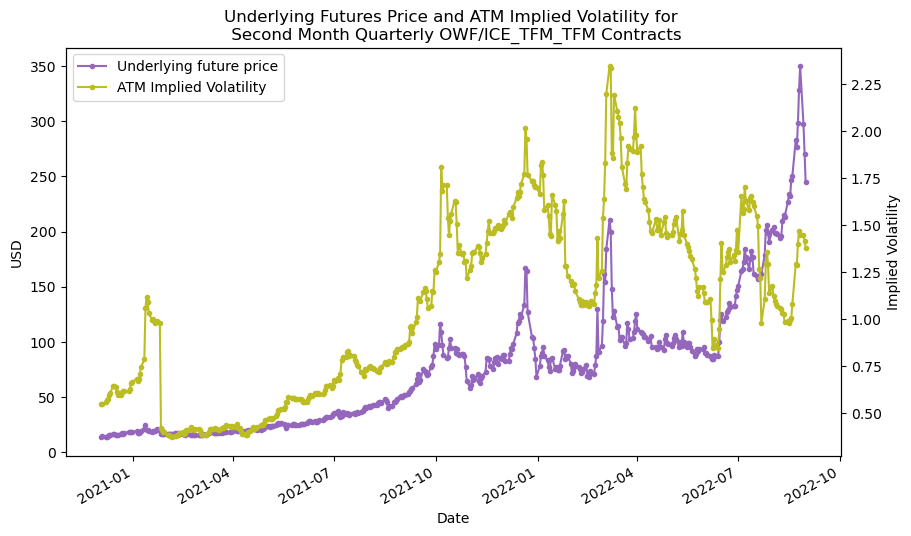

In [247]:
plt.figure()
ax1 = second_month_data['Future'].plot(
    marker='o', markersize=3,
    color='C4', xlabel='Date',
    ylabel='USD',
    figsize=(10, 6)
)
ax2 = second_month_data['AtM'].plot(
    marker='o',markersize=3, mark_right=False,
    color='C8', ylabel='Implied Volatility',
    secondary_y=True,
)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, ['Underlying future price', 'ATM Implied Volatility'], loc='best')
plt.title('Underlying Futures Price and ATM Implied Volatility for \n Second Month Quarterly OWF/ICE_TFM_TFM Contracts')
None

At this point, it is helpful to define our above workflow in a function, which will make it quicker and easier to analyze our pairs. We'll define a function that takes a Quandl code and dates, and returns a DataFrame like `second_month_data` above.

In [248]:
def get_second_month_quarterly(code: str, trim_start: str, trim_end: str, only_quarterly=True):
    """
    Returns second month quarterly futures data for Quandl code `code`.
    Productionizes the above workflow.
    """
    # Parse year from `trim_start` and `trim_end`
    year_start = pd.to_datetime(trim_start).year
    year_end = pd.to_datetime(trim_end).year + 1
    
    # Fetch all necessary feeds
    data_raw = fetch_quandl(
        feeds=tuple(get_quandl_codes_quarterly(year_start, year_end, code)),
        trim_start=trim_start, trim_end=trim_end
    )
    
    # Index data appropriately
    df = index_owf_futures_data(data_raw, stub=code)
    
    # Include only quarterly contracts
    if only_quarterly:
        is_quarterly_contract = df.index.get_level_values(1).to_series().apply(lambda x: x.month).isin([3, 6, 9, 12]).tolist()
        df = df.loc[is_quarterly_contract, :]
    
    # Find second month contract
    second_month_data = df.groupby('Date').agg(loc_second_month_contract)
    return second_month_data

Now, we can start analyzing spreads. I'll be looking at the pairs:

- `0. ICE_TFM_TFM (W) versus NYM_NG_NG (X) × 13.7261`
- `6. CBT_TU_TU (Y) versus CBT_US_US (Z) × 0.6873`

for the dates 3 Dec 2020 though 31 Aug 2022. We start by pulling and cleaning data for each asset:

In [249]:
trim_start, trim_end = '2020-12-03', '2022-08-31'
tfm_raw = get_second_month_quarterly('OWF/ICE_TFM_TFM', trim_start, trim_end)
ng_raw = get_second_month_quarterly('OWF/NYM_NG_NG', trim_start, trim_end)
tu_raw = get_second_month_quarterly('OWF/CBT_TU_TU', trim_start, trim_end)
us_raw = get_second_month_quarterly('OWF/CBT_US_US', trim_start, trim_end)

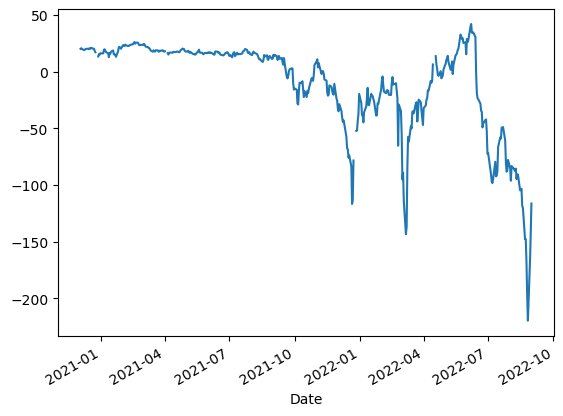

In [251]:
spread0 = (ng_raw['Future'] * 13.7261) - tfm_raw['Future']
spread0.plot()
None

We can calculate a moving average of this series over the past `window` days:

count    385.000000
mean      -4.010299
std       17.960610
min      -93.175835
10%      -24.917502
50%       -0.538061
90%       10.694316
max       44.540975
Name: Future, dtype: float64

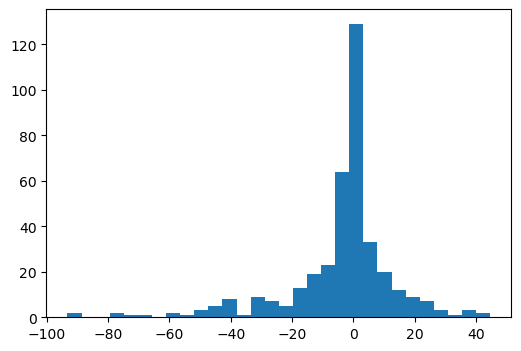

In [275]:
def moving_average(df, window=5):
    return df.rolling(window=window).mean()

def n_day_trend(df, window):
    return df - moving_average(df, window=window)

n_day_trend(spread0, window=14).hist(
    figsize=(6, 4), bins=30, grid=False,
)
n_day_trend(spread0, window=14).describe(percentiles=[.1, .5, .9])

In [286]:
spread0_past_year = spread0.loc[pd.to_datetime('today') - pd.to_timedelta(365, 'D') : pd.to_datetime('today')]

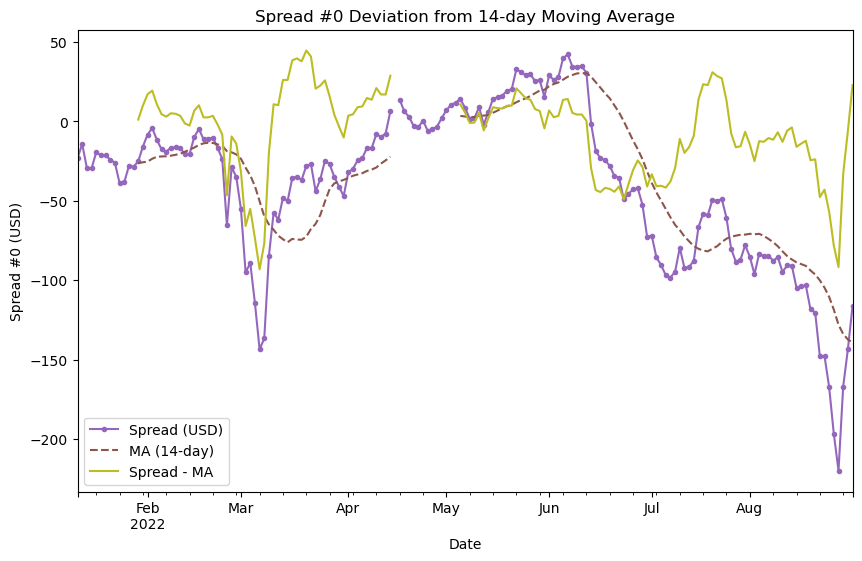

In [288]:
plt.figure()
ax1 = spread0_past_year.plot(
    marker='o', markersize=3,
    color='C4', xlabel='Date',
    ylabel='Spread #0 (USD)',
    figsize=(10, 6)
)
ax2 = moving_average(spread0_past_year, window=14).plot(
    style='C5--',
)
ax3 = n_day_trend(spread0_past_year, window=14).plot(
    style='C8-',
)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
ax1.legend(h1+h2+h3, ['Spread (USD)', 'MA (14-day)', 'Spread - MA'], loc='best')
plt.title('Spread #0 Deviation from 14-day Moving Average')
None

**TODO:** train and test [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) models to the spread and trend timeseries, separately.